In [1]:
from numpy import *
import scipy as sp
from pandas import *
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
import numpy as np
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

: 

: 

## Check for Collinearity

In [1]:
conn = sqlite3.connect('data/mm_stats.gpkg')                                

# geometry column name is in gpkg_geometry_columns
# let'S pretend we already know it is 'Shape' for this dataset
sql = """
    SELECT
      fid,
      iso_code,
      region,
      shdi,
      population,
      subnational_shdi_healthindex,
      subnational_shdi_incindex,
      subnational_shdi_edindex,
      internet_users_cleaned,
      cellphone_users_cleaned,
      rule_of_law_cleaned,
      gender_equality_cleaned,
      youthmappers,
      open_cities,
      death_per_100k
    FROM centroids_with_all_stats_2
"""
df = pd.read_sql(sql, con=conn)
df["population"] = np.log10(df["population"])
display(df)

NameError: name 'sqlite3' is not defined

Inspect VIFs

shdi                       1.284421
population                 1.088342
gender_equality_cleaned    1.141058
youthmappers               1.051491
death_per_100k             1.135814
Name: VIF, dtype: float64

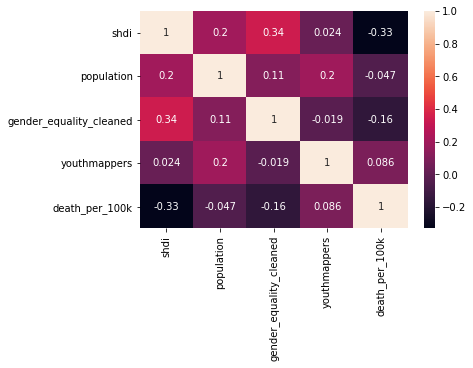

<Figure size 360x360 with 0 Axes>

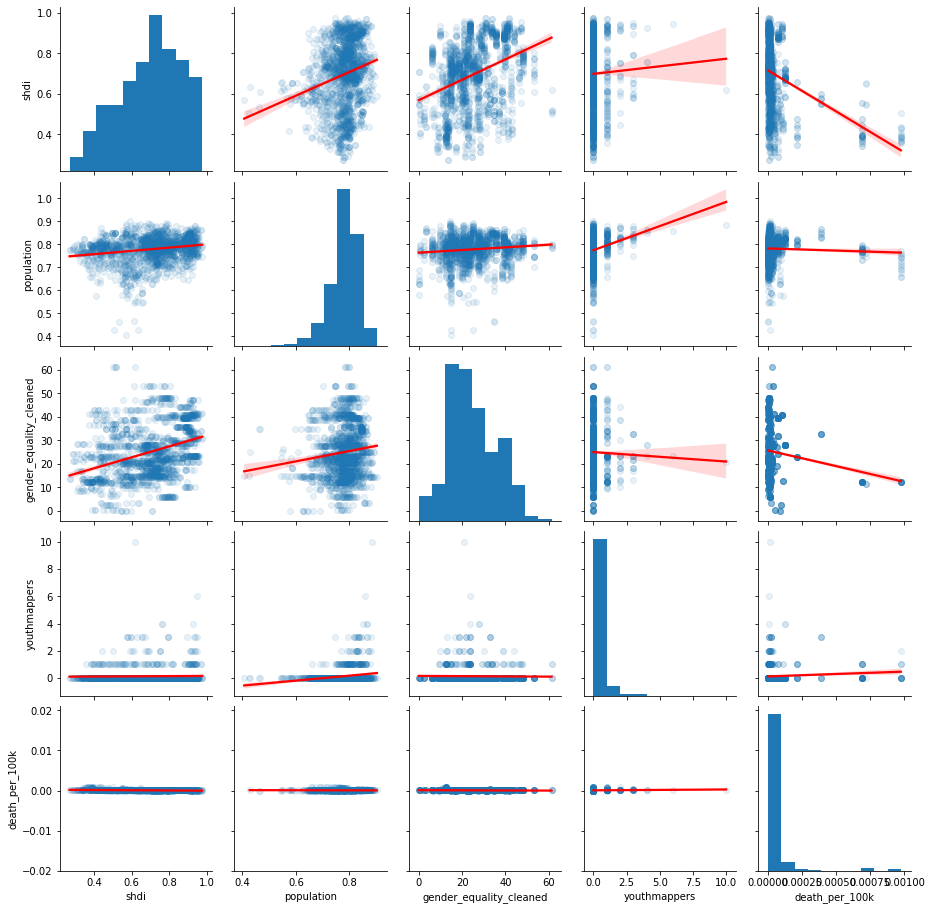

In [3]:
columns = [
    "shdi",
    "population",
    # "subnational_shdi_healthindex",
    # "subnational_shdi_incindex",
    # "subnational_shdi_edindex",
    # "internet_users_cleaned",
    # "cellphone_users_cleaned",
    # "rule_of_law_cleaned",
    "gender_equality_cleaned",
    "youthmappers",
    "death_per_100k"
    # "open_cities"
]

vifs = pd.Series(np.linalg.inv(df[columns].corr().to_numpy()).diagonal(), 
                 index=df[columns].columns, 
                 name='VIF')
display(vifs)

corrMatrix = df[columns].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

w, v = np.linalg.eig(corrMatrix)

plt.figure(figsize=(5,5))
sns.pairplot(
    df[columns],
    kind='reg',
    plot_kws={
        'line_kws':{'color':'red'},
        'scatter_kws': {'alpha': 0.1}
    }
)
plt.show()

# R Workflow
### Load Data and Define KNN Neighbourhood

In [4]:
layer_name = "centroids_with_all_stats_2"

ro.r(f'''
library(magrittr) # needs to be run every time you start R and want to use %>%
library(dplyr)    # alternatively, this also loads %>%
library(tidyr)
library(sf)
library(spdep)
datSf <- read_sf(dsn="data/mm_stats.gpkg", layer="{layer_name}")
datSf <- datSf %>% distinct(.keep_all = TRUE)
names(datSf)
datSf <- datSf %>% replace_na(list(
    tm_creation_buildings = 0,
    tm_creation_highways = 0,
    tm_creation_residential = 0,
    all_creation_residential = 0,
    all_creation_buildings = 0,
    all_creation_highways = 0,
    youthmappers_norm = 0,
    youthmappers = 0,
    death_per_100k = 0,
    death_per_100k_norm = 0
    )
)
datSf <- datSf[!st_is_empty(datSf),,drop=FALSE]
datSp <- as(datSf, "Spatial")
coords <- st_centroid(st_geometry(datSf), of_largest_polygon=TRUE)
dat.nbk10 <- knn2nb(knearneigh(coords, k=10))
dat.lwk10 <- nb2listw(dat.nbk10, style="W")
''')

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘tidyr’


R[write to console]: The following object is masked from ‘package:magrittr’:

    extract


R[write to console]: Linking to GEOS 3.7.2, GDAL 2.4.2, PROJ 5.2.0

R[write to console]: Loading required package: sp

R[write to console]: Loading required package: spData

R[write to console]: To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`



style,[RTYPES.STRSXP]
neighbours,[RTYPES.VECSXP]
weights,[RTYPES.VECSXP]


### Model with added Covariates
This model uses the following variables:
* SHDI
* log(population)
* cellphone_users (share of people that own a cellphone)'
* gender_equality (share of women in parliament)
* number youthmappers chapters
* deaths from disaster per 100k inhabitants since 2012

The problem is that we still have a relatively high correlation between SHDI and cellphone users and this might mislead the results. The overall explained deviance is not increasing much when adding this covariate. Hence, I would assume that it is also not adding much value to the analysis?

In [16]:
columns = [
    "buildings",
    "highways",
    #"residential"
]

groups = [
    "all",
    "tm"
]


for group in groups:

    for i, column in enumerate(columns):

        out = ro.r(f'''
        sevm_{group}_B_{column} <- spatialreg::ME(
            {group}_creation_{column} ~
                # subnational_shdi_healthindex_norm +
                # subnational_shdi_incindex_norm +
                # subnational_shdi_edindex_norm +
                shdi_norm +
                # internet_users_cleaned_norm +
                cellphone_users_cleaned_norm +
                # rule_of_law_cleaned_norm +
                gender_equality_cleaned_norm +
                youthmappers_norm +
                # open_cities_norm + 
                death_per_100k_norm +
                log(population),
            family=poisson,
            data=datSp,
            listw =dat.lwk10
        )
        sevm_{group}_Bqp_{column} <- spatialreg::ME(
            {group}_creation_{column} ~
                # subnational_shdi_healthindex_norm +
                # subnational_shdi_incindex_norm +
                # subnational_shdi_edindex_norm +
                shdi_norm +
                # internet_users_cleaned_norm +
                cellphone_users_cleaned_norm +
                # rule_of_law_cleaned_norm +
                gender_equality_cleaned_norm +
                youthmappers_norm +
                # open_cities_norm + 
                death_per_100k_norm +
                log(population),
            family=quasipoisson,
            data=datSp,
            listw =dat.lwk10
        )
        g_{group}_poisBqp_sevm_{column} <- glm(
            {group}_creation_{column} ~
                # subnational_shdi_healthindex_norm +
                # subnational_shdi_incindex_norm +
                # subnational_shdi_edindex_norm +
                shdi_norm +
                # internet_users_cleaned_norm +
                cellphone_users_cleaned_norm +
                # rule_of_law_cleaned_norm +
                gender_equality_cleaned_norm +
                youthmappers_norm +
                # open_cities_norm +
                death_per_100k_norm +
                log(population) +
                fitted(sevm_{group}_Bqp_{column}),
            family = quasipoisson,
            data = datSf
        )
        datSf$resid_{group}_{column} <- residuals(g_{group}_poisBqp_sevm_{column})
        summary(g_{group}_poisBqp_sevm_{column})
        ''')
        print(column)
        print(out)

        out = ro.r(f'''
        1 - g_{group}_poisBqp_sevm_{column}$deviance / g_{group}_poisBqp_sevm_{column}$null.deviance
        ''')
        print(out)
        print("""
        ######################################################################
        """)

out = ro.r(f"""
    write.csv(datSf, "data/glm_results_and_residuals.csv")
""")

buildings

Call:
glm(formula = all_creation_buildings ~ shdi_norm + cellphone_users_cleaned_norm + 
    gender_equality_cleaned_norm + youthmappers_norm + death_per_100k_norm + 
    log(population) + fitted(sevm_all_Bqp_buildings), family = quasipoisson, 
    data = datSf)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-3077.17   -289.28    -72.27    129.16   2025.78  

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          -12.33599    0.62342 -19.788  < 2e-16 ***
shdi_norm                              0.41532    0.03835  10.831  < 2e-16 ***
cellphone_users_cleaned_norm           0.11091    0.03403   3.259  0.00114 ** 
gender_equality_cleaned_norm           0.21865    0.02994   7.303 4.54e-13 ***
youthmappers_norm                      0.03491    0.01258   2.774  0.00560 ** 
death_per_100k_norm                    0.38727    0.04296   9.014  < 2e-16 ***
log(population)                   

## Simple Model
use the following variables:
* SHDI
* log(population)
* gender_equality
* youthmappers
* deaths from disaster per 100k inhabitants since 2012

In [17]:
columns = [
    "buildings",
    "highways",
    #"residential"
]

groups = [
    "all",
    "tm"
]


for group in groups:

    for i, column in enumerate(columns):

        out = ro.r(f'''
        sevm_{group}_B_{column} <- spatialreg::ME(
            {group}_creation_{column} ~
                # subnational_shdi_healthindex_norm +
                # subnational_shdi_incindex_norm +
                # subnational_shdi_edindex_norm +
                shdi_norm +
                # internet_users_cleaned_norm +
                # cellphone_users_cleaned_norm +
                # rule_of_law_cleaned_norm +
                gender_equality_cleaned_norm +
                youthmappers_norm +
                death_per_100k_norm +
                # open_cities_norm + 
                log(population),
            family=poisson,
            data=datSp,
            listw =dat.lwk10
        )
        sevm_{group}_Bqp_{column} <- spatialreg::ME(
            {group}_creation_{column} ~
                # subnational_shdi_healthindex_norm +
                # subnational_shdi_incindex_norm +
                # subnational_shdi_edindex_norm +
                shdi_norm +
                # internet_users_cleaned_norm +
                # cellphone_users_cleaned_norm +
                # rule_of_law_cleaned_norm +
                gender_equality_cleaned_norm +
                youthmappers_norm +
                # open_cities_norm + 
                death_per_100k_norm +
                log(population),
            family=quasipoisson,
            data=datSp,
            listw =dat.lwk10
        )
        g_{group}_poisBqp_sevm_{column} <- glm(
            {group}_creation_{column} ~
                # subnational_shdi_healthindex_norm +
                # subnational_shdi_incindex_norm +
                # subnational_shdi_edindex_norm +
                shdi_norm +
                # internet_users_cleaned_norm +
                # cellphone_users_cleaned_norm +
                # rule_of_law_cleaned_norm +
                gender_equality_cleaned_norm +
                youthmappers_norm +
                # open_cities_norm + 
                death_per_100k_norm +
                log(population) +
                fitted(sevm_{group}_Bqp_{column}),
            family = quasipoisson,
            data = datSf
        )
        datSf$resid_{group}_{column}_model2 <- residuals(g_{group}_poisBqp_sevm_{column})
        summary(g_{group}_poisBqp_sevm_{column})
        ''')
        print(column)
        print(out)

        out = ro.r(f'''
        1 - g_{group}_poisBqp_sevm_{column}$deviance / g_{group}_poisBqp_sevm_{column}$null.deviance
        ''')
        print(out)
        print("""
        ######################################################################
        """)

out = ro.r(f"""
    write.csv(datSf, "data/glm_results_and_residuals.csv")
""")

buildings

Call:
glm(formula = all_creation_buildings ~ shdi_norm + gender_equality_cleaned_norm + 
    youthmappers_norm + death_per_100k_norm + log(population) + 
    fitted(sevm_all_Bqp_buildings), family = quasipoisson, data = datSf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3235.3   -291.6    -74.5    128.2   2121.3  

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          -13.08144    0.64574 -20.258  < 2e-16 ***
shdi_norm                              0.46389    0.03260  14.230  < 2e-16 ***
gender_equality_cleaned_norm           0.20774    0.02909   7.140 1.44e-12 ***
youthmappers_norm                      0.02444    0.01242   1.968 0.049244 *  
death_per_100k_norm                    0.42769    0.04073  10.501  < 2e-16 ***
log(population)                       13.65316    0.34077  40.066  < 2e-16 ***
fitted(sevm_all_Bqp_buildings)vec85   -4.72887    0.47550  -9.945  < 2e-16 ***
f

### Initial Model
The initial model only used the following covariates:
* SHDI
* log(population)

In [38]:
columns = [
    "buildings",
    "highways",
    #"residential"
]

groups = [
    "all",
    "tm"
]


for group in groups:

    for i, column in enumerate(columns):

        out = ro.r(f'''
        sevm_{group}_B_{column} <- spatialreg::ME(
            {group}_creation_{column} ~
                # subnational_shdi_healthindex_norm +
                # subnational_shdi_incindex_norm +
                # subnational_shdi_edindex_norm +
                shdi_norm +
                # internet_users_cleaned_norm +
                # cellphone_users_cleaned_norm +
                # rule_of_law_cleaned_norm +
                # gender_equality_cleaned_norm +
                # youthmappers_norm +
                # open_cities_norm + 
                log(population),
            family=poisson,
            data=datSp,
            listw =dat.lwk10
        )
        sevm_{group}_Bqp_{column} <- spatialreg::ME(
            {group}_creation_{column} ~
                # subnational_shdi_healthindex_norm +
                # subnational_shdi_incindex_norm +
                # subnational_shdi_edindex_norm +
                shdi_norm +
                # internet_users_cleaned_norm +
                # cellphone_users_cleaned_norm +
                # rule_of_law_cleaned_norm +
                # gender_equality_cleaned_norm +
                # youthmappers_norm +
                # open_cities_norm + 
                log(population),
            family=quasipoisson,
            data=datSp,
            listw =dat.lwk10
        )
        g_{group}_poisBqp_sevm_{column} <- glm(
            {group}_creation_{column} ~
                # subnational_shdi_healthindex_norm +
                # subnational_shdi_incindex_norm +
                # subnational_shdi_edindex_norm +
                shdi_norm +
                # internet_users_cleaned_norm +
                # cellphone_users_cleaned_norm +
                # rule_of_law_cleaned_norm +
                # gender_equality_cleaned_norm +
                # youthmappers_norm +
                # open_cities_norm + 
                log(population) +
                fitted(sevm_{group}_Bqp_{column}),
            family = quasipoisson,
            data = datSf
        )
        datSf$resid_{group}_{column}_model0 <- residuals(g_{group}_poisBqp_sevm_{column})
        summary(g_{group}_poisBqp_sevm_{column})
        ''')
        print(column)
        print(out)

        out = ro.r(f'''
        1 - g_{group}_poisBqp_sevm_{column}$deviance / g_{group}_poisBqp_sevm_{column}$null.deviance
        ''')
        print(out)
        print("""
        ######################################################################
        """)

out = ro.r(f"""
    write.csv(datSf, "data/glm_results_and_residuals.csv")
""")

buildings

Call:
glm(formula = all_creation_buildings ~ shdi_norm + log(population) + 
    fitted(sevm_all_Bqp_buildings), family = quasipoisson, data = datSf)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-3009.46   -316.20    -84.23    165.14   2037.63  

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          -10.82539    1.16387  -9.301  < 2e-16 ***
shdi_norm                              0.47929    0.06243   7.677 2.90e-14 ***
log(population)                       12.36993    0.60939  20.299  < 2e-16 ***
fitted(sevm_all_Bqp_buildings)vec85   -6.58918    0.92078  -7.156 1.29e-12 ***
fitted(sevm_all_Bqp_buildings)vec45  -10.99715    2.95562  -3.721 0.000206 ***
fitted(sevm_all_Bqp_buildings)vec6   -38.52918    4.84526  -7.952 3.55e-15 ***
fitted(sevm_all_Bqp_buildings)vec113  -2.13732    0.94504  -2.262 0.023861 *  
fitted(sevm_all_Bqp_buildings)vec58    4.57081    0.85881   5.322 1.1

## Without SEVM

In [5]:
columns = [
    "buildings",
    "highways",
    #"residential"
]

groups = [
    "all",
    "tm"
]


for group in groups:

    for i, column in enumerate(columns):

        out = ro.r(f'''
        sevm_{group}_B_{column} <- spatialreg::ME(
            {group}_creation_{column} ~
                # subnational_shdi_healthindex_norm +
                # subnational_shdi_incindex_norm +
                # subnational_shdi_edindex_norm +
                shdi_norm +
                # internet_users_cleaned_norm +
                cellphone_users_cleaned_norm +
                # rule_of_law_cleaned_norm +
                gender_equality_cleaned_norm +
                youthmappers_norm +
                # open_cities_norm + 
                death_per_100k_norm +
                log(population),
            family=poisson,
            data=datSp,
            listw =dat.lwk10
        )
        sevm_{group}_Bqp_{column} <- spatialreg::ME(
            {group}_creation_{column} ~
                # subnational_shdi_healthindex_norm +
                # subnational_shdi_incindex_norm +
                # subnational_shdi_edindex_norm +
                shdi_norm +
                # internet_users_cleaned_norm +
                cellphone_users_cleaned_norm +
                # rule_of_law_cleaned_norm +
                gender_equality_cleaned_norm +
                youthmappers_norm +
                # open_cities_norm + 
                death_per_100k_norm +
                log(population),
            family=quasipoisson,
            data=datSp,
            listw =dat.lwk10
        )
        g_{group}_poisBqp_sevm_{column} <- glm(
            {group}_creation_{column} ~
                # subnational_shdi_healthindex_norm +
                # subnational_shdi_incindex_norm +
                # subnational_shdi_edindex_norm +
                shdi_norm +
                # internet_users_cleaned_norm +
                cellphone_users_cleaned_norm +
                # rule_of_law_cleaned_norm +
                gender_equality_cleaned_norm +
                youthmappers_norm +
                # open_cities_norm +
                death_per_100k_norm +
                log(population),
            family = quasipoisson,
            data = datSf
        )
        summary(g_{group}_poisBqp_sevm_{column})
        ''')
        print(column)
        print(out)

        out = ro.r(f'''
        1 - g_{group}_poisBqp_sevm_{column}$deviance / g_{group}_poisBqp_sevm_{column}$null.deviance
        ''')
        print(out)
        print("""
        ######################################################################
        """)


R[write to console]: Registered S3 methods overwritten by 'spatialreg':
  method                   from 
  residuals.stsls          spdep
  deviance.stsls           spdep
  coef.stsls               spdep
  print.stsls              spdep
  summary.stsls            spdep
  print.summary.stsls      spdep
  residuals.gmsar          spdep
  deviance.gmsar           spdep
  coef.gmsar               spdep
  fitted.gmsar             spdep
  print.gmsar              spdep
  summary.gmsar            spdep
  print.summary.gmsar      spdep
  print.lagmess            spdep
  summary.lagmess          spdep
  print.summary.lagmess    spdep
  residuals.lagmess        spdep
  deviance.lagmess         spdep
  coef.lagmess             spdep
  fitted.lagmess           spdep
  logLik.lagmess           spdep
  fitted.SFResult          spdep
  print.SFResult           spdep
  fitted.ME_res            spdep
  print.ME_res             spdep
  print.lagImpact          spdep
  plot.lagImpact           spdep
  su

buildings

Call:
glm(formula = all_creation_buildings ~ shdi_norm + cellphone_users_cleaned_norm + 
    gender_equality_cleaned_norm + youthmappers_norm + death_per_100k_norm + 
    log(population), family = quasipoisson, data = datSf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2472.2   -371.5   -118.4    125.5   2801.2  

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  -10.928593   0.773859 -14.122   <2e-16 ***
shdi_norm                      0.630033   0.045911  13.723   <2e-16 ***
cellphone_users_cleaned_norm  -0.003832   0.041803  -0.092    0.927    
gender_equality_cleaned_norm   0.379739   0.033644  11.287   <2e-16 ***
youthmappers_norm             -0.007631   0.017825  -0.428    0.669    
death_per_100k_norm            0.585518   0.048132  12.165   <2e-16 ***
log(population)               12.556560   0.404752  31.023   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.

## Normalize data
Use the mean and the standard deviation to normalize the data. This has been applied at the very beginning.

In [46]:
columns = [
    "shdi",
    "population",
    "subnational_shdi_healthindex",
    "subnational_shdi_incindex",
    "subnational_shdi_edindex",
    "internet_users_cleaned",
    "cellphone_users_cleaned",
    "rule_of_law_cleaned",
    "gender_equality_cleaned",
    "youthmappers",
    "open_cities"
]

for column in columns:
    print(column)
    df[f"{column}_norm"] = (df[column] - df[column].mean())/df[column].std()
    
    
display(df)
df.to_csv("data/normalized_data.csv")

shdi
population
subnational_shdi_healthindex
subnational_shdi_incindex
subnational_shdi_edindex
internet_users_cleaned
cellphone_users_cleaned
rule_of_law_cleaned
gender_equality_cleaned
youthmappers
open_cities


,fid,iso_code,region,shdi,population,subnational_shdi_healthindex,subnational_shdi_incindex,subnational_shdi_edindex,internet_users_cleaned,cellphone_users_cleaned,...,population_norm,subnational_shdi_healthindex_norm,subnational_shdi_incindex_norm,subnational_shdi_edindex_norm,internet_users_cleaned_norm,cellphone_users_cleaned_norm,rule_of_law_cleaned_norm,gender_equality_cleaned_norm,youthmappers_norm,open_cities_norm
0,1,AFG,Central (Kabul Wardak Kapisa Logar Parwan Panj...,0.575,6.788519,0.703,0.471,0.574,11.447688,59.356020,...,0.992191,-0.767446,-1.130040,-0.304479,-1.505205,-1.568279,-1.673398,0.185154,-0.240090,-0.12338
1,2,AFG,West (Ghor Herat Badghis Farah),0.465,6.214601,0.668,0.424,0.354,11.447688,59.356020,...,0.221370,-1.049512,-1.390318,-1.434607,-1.505205,-1.568279,-1.673398,0.185154,-0.240090,-0.12338
2,3,AGO,"Norte (Zaire, Uige, Malange)",0.556,6.303113,0.672,0.555,0.462,14.339079,46.598638,...,0.340250,-1.017275,-0.664862,-0.879817,-1.402913,-1.979894,-0.192274,0.448957,NaN,-0.12338
3,4,ARG,"Catamarca, La Rioja, San Juan",0.825,6.123563,0.872,0.790,0.814,74.294907,130.874399,...,0.099098,0.594529,0.636527,0.928387,0.718208,0.739251,0.238595,1.410337,-0.240090,-0.12338
4,5,ARG,"Chaco, Formosa",0.801,6.176020,0.872,0.752,0.784,74.294907,130.874399,...,0.169551,0.594529,0.426090,0.774279,0.718208,0.739251,0.238595,1.410337,-0.240090,-0.12338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,1738,ZMB,Copperbelt,0.670,6.351226,0.688,0.644,0.680,14.299997,96.414412,...,0.404868,-0.888331,-0.171996,0.240037,-1.404296,-0.372595,-0.644923,-0.722226,3.488625,-0.12338
1729,1739,ZMB,Western,0.531,5.923726,0.668,0.442,0.506,14.299997,96.414412,...,-0.169300,-1.049512,-1.290637,-0.653792,-1.404296,-0.372595,-0.644923,-0.722226,-0.240090,-0.12338
1730,1740,ZWE,Bulawayo,0.640,5.877565,0.711,0.564,0.654,27.055488,90.102290,...,-0.231299,-0.702974,-0.615022,0.106476,-0.953031,-0.576255,-1.445906,0.612728,-0.240090,-0.12338
1731,1741,ZWE,Matebeleland North,0.500,5.905784,0.672,0.377,0.492,27.055488,90.102290,...,-0.193399,-1.017275,-1.650596,-0.725709,-0.953031,-0.576255,-1.445906,0.612728,-0.240090,-0.12338
